<a href="https://colab.research.google.com/github/michel-wue/Seminar/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-tabnet
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/887.5 MB 34.1 MB/s eta 0:00:23
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=6abb21f91ea4476fb766fd8ae73082f9fb1a140e3280d57e4605ddd6da00596d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [15]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [ ]:
#!pip install pandas-profiling

In [5]:
import requests as r
import pandas as pd
from pandas import json_normalize
import re
from google.colab import drive
import datetime
from os import times
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import dask.dataframe as dd
import seaborn as sn
import pickle
#import pandas_profiling


In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
play_data = pd.read_csv(
    '/content/drive/MyDrive/seminar/full_data3.csv'
)

,pred,actual_values
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
70972,0,0
70973,0,0
70974,0,0
70975,0,0


In [ ]:
import pandas as pd
from datetime import timedelta
play_data['clock'] = play_data['clock'].apply(lambda x: timedelta(days=int(x.split()[0]), hours=int(x.split()[2].split(':')[0]), minutes=int(x.split()[2].split(':')[1]), seconds=int(x.split()[2].split(':')[2])).total_seconds() / 60.0)
play_data['time_remaining'] = np.where(play_data['quarter'] == 1, play_data['clock'] + 45, play_data['clock'])
play_data['time_remaining'] = np.where(play_data['quarter'] == 2, play_data['clock'] + 30, play_data['time_remaining'])
play_data['time_remaining'] = np.where(play_data['quarter'] == 3, play_data['clock'] + 15, play_data['time_remaining'])
play_data['time_remaining'] = np.where(play_data['quarter'] == 4, play_data['clock'], play_data['time_remaining'])
play_data['time_remaining'] = np.where(play_data['quarter'] == 5, play_data['clock'], play_data['time_remaining'])
play_data.loc[play_data['Winner'] == 'Home', 'Winner'] = 1
play_data.loc[play_data['Winner'] == 'Away', 'Winner'] = 0
play_data['Winner'] = play_data['Winner'].astype(int)


NameError: ignored

In [ ]:
def calculate_scoring_game(point_diff):
    if point_diff <= 7:
        return 1
    elif 7 < point_diff < 15:
        return 2
    elif 15 <= point_diff < 22:
        return 3
    else:
        return 4

In [ ]:
#play_data['point_difference'] = 0
for index,row in play_data.iterrows():
  if row['homeScore'] > row['awayScore']:
    play_data.at[index, 'leading_Team'] = row['Home_teamname']
  elif row['homeScore'] < row['awayScore']:
    play_data.at[index, 'leading_Team'] = row['Away_teamname']
  else:
    play_data.at[index, 'leading_Team'] = 'tie'
  point_diff = abs(row['homeScore'] - row['awayScore'])
  play_data.at[index, 'point_difference'] = point_diff

play_data['scoring_game'] = play_data['point_difference'].apply(calculate_scoring_game)


In [ ]:
play_data.to_csv('/content/drive/MyDrive/seminar/data_final.csv', index=False)

NameError: ignored

<ipython-input-20-33af7649f9ff>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = play_data.corr().abs()


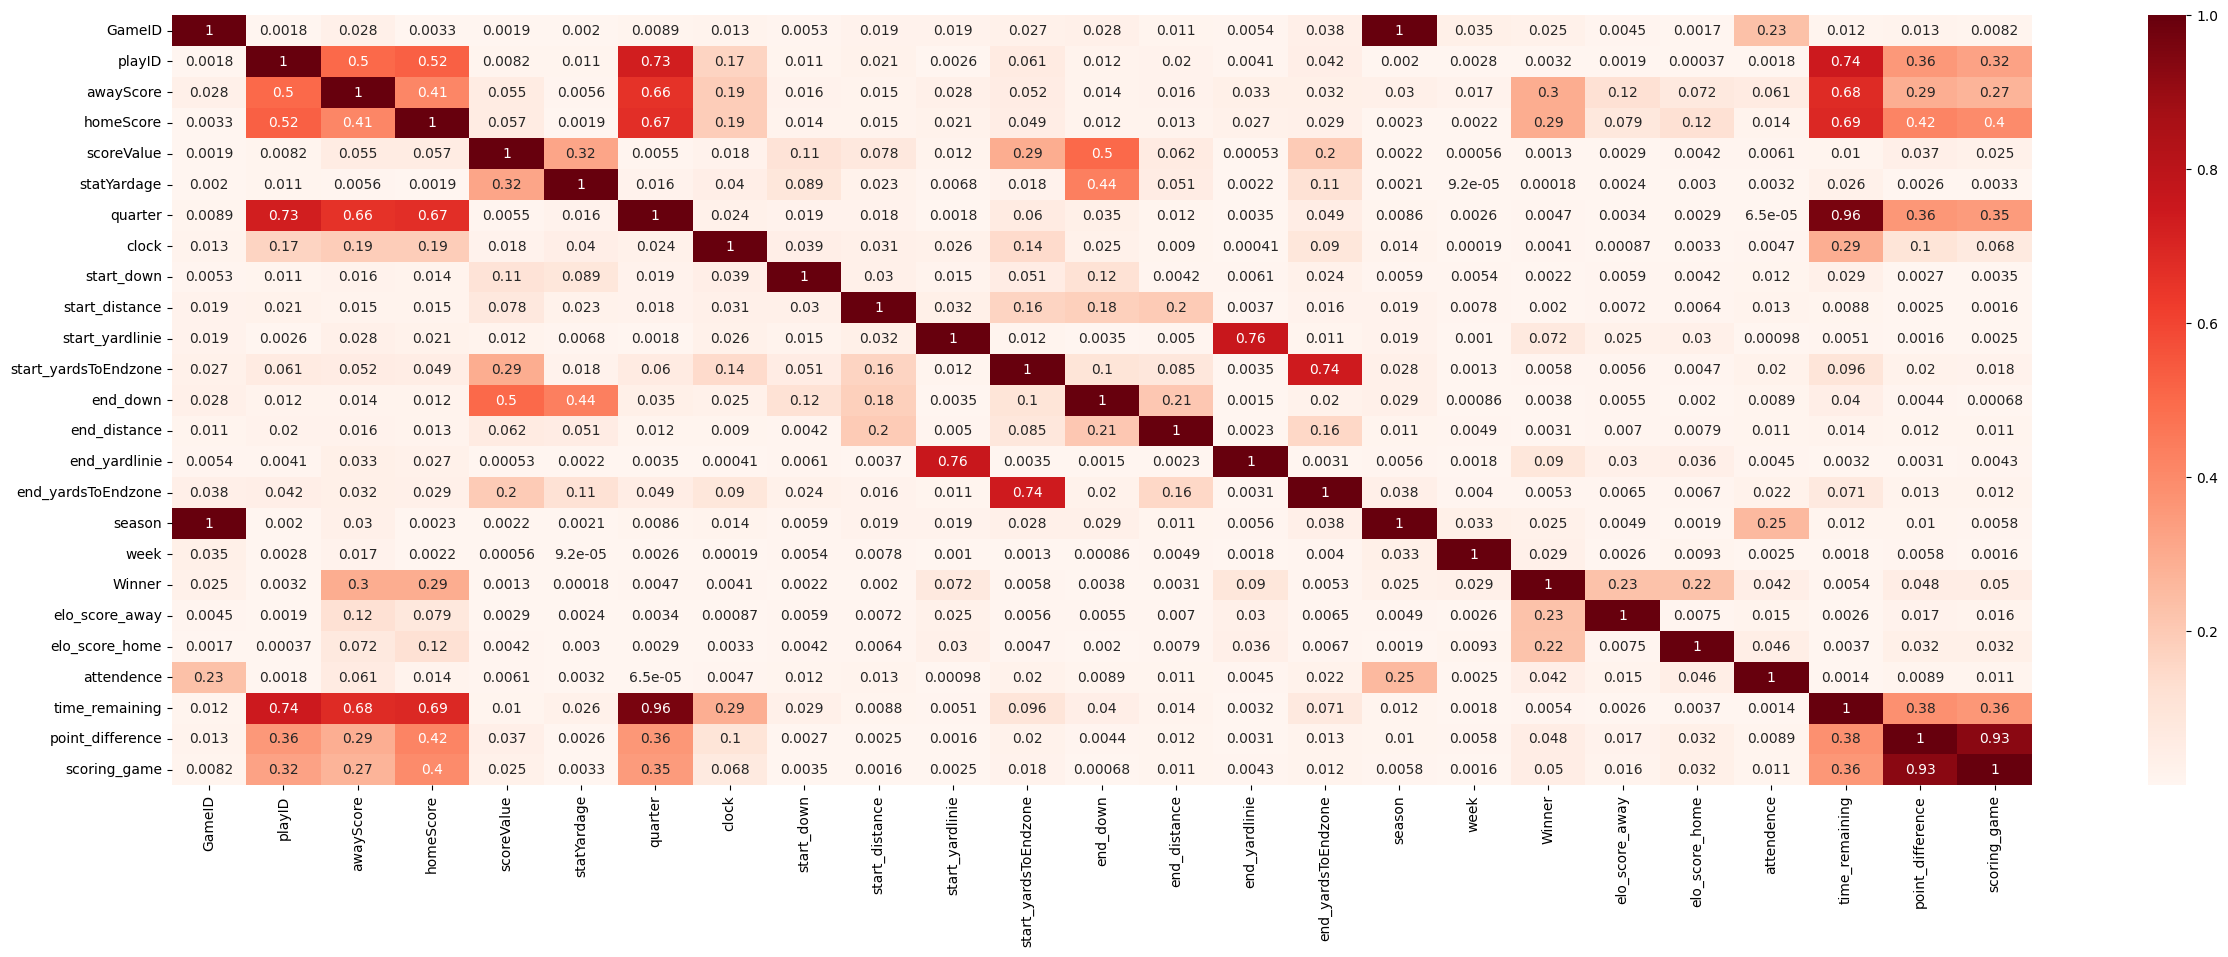

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn

corr_matrix = play_data.corr().abs()


plt.figure(figsize=(30,10))
sn.heatmap(corr_matrix , annot=True, cmap="Reds")
plt.show()

In [7]:
play_data = pd.read_csv('/content/drive/MyDrive/seminar/data_final.csv')

In [8]:
play_data

,GameID,playID,awayScore,homeScore,scoreValue,statYardage,quarter,clock,type_text,team_play,...,Winner,Home_teamname,Away_teamname,elo_score_away,elo_score_home,attendence,time_remaining,leading_Team,point_difference,scoring_game
0,400951620,40095162037,0,0,0,0,1,15.000000,Kickoff,cin,...,0,cin,hou,1451.21,1476.20,0.808090,60.000000,tie,0.0,1
1,400951620,40095162052,0,0,0,4,1,15.000000,Rush,hou,...,0,cin,hou,1451.21,1476.20,0.808090,60.000000,tie,0.0,1
2,400951620,40095162073,0,0,0,0,1,14.416667,Pass Incompletion,hou,...,0,cin,hou,1451.21,1476.20,0.808090,59.416667,tie,0.0,1
3,400951620,400951620102,0,0,0,0,1,14.316667,Pass Incompletion,hou,...,0,cin,hou,1451.21,1476.20,0.808090,59.316667,tie,0.0,1
4,400951620,400951620124,0,0,0,33,1,14.233333,Punt,hou,...,0,cin,hou,1451.21,1476.20,0.808090,59.233333,tie,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356583,401437952,4014379523753,20,16,0,2,4,2.000000,Rush,det,...,0,gb,det,1485.30,1557.21,0.964833,2.000000,det,4.0,1
356584,401437952,4014379523764,20,16,0,0,4,1.250000,Timeout,det,...,0,gb,det,1485.30,1557.21,0.964833,1.250000,det,4.0,1
356585,401437952,4014379523774,20,16,0,9,4,1.233333,Pass Reception,det,...,0,gb,det,1485.30,1557.21,0.964833,1.233333,det,4.0,1
356586,401437952,4014379523812,20,16,0,-1,4,0.550000,Rush,det,...,0,gb,det,1485.30,1557.21,0.964833,0.550000,det,4.0,1


In [9]:

import numpy as np
from sklearn.model_selection import train_test_split

# Extrahieren der eindeutigen GameIDs aus dem play_data-Datensatz
unique_game_ids = play_data['GameID'].unique()

# Aufteilen der eindeutigen GameIDs in Trainings-, Validierungs- und Testsets
train_game_ids, remaining_game_ids = train_test_split(unique_game_ids, test_size=0.2, random_state=42)
train_game_ids, valid_game_ids = train_test_split(train_game_ids, test_size=0.2, random_state=42)
test_game_ids =remaining_game_ids

# Aufteilen des play_data-Datensatzes basierend auf den GameIDs
train_df = play_data[play_data['GameID'].isin(train_game_ids)]
valid_df = play_data[play_data['GameID'].isin(valid_game_ids)]
test_df = play_data[play_data['GameID'].isin(test_game_ids)]


In [9]:
print(len(train_df))

229235


In [33]:
#train_val_df = play_data.iloc[:285610, :]
#test_df = play_data.iloc[285610:356587, :]
#valid_df = train_val_df.iloc[:7170, :]
#train_df = train_val_df.iloc[7170:285610, :]
#train_df = test_df.drop_duplicates()
#valid_df = valid_df.drop_duplicates()
#test_df = test_df.drop_duplicates()


In [10]:
train_game_ids = set(train_df['GameID'])
valid_game_ids = set(valid_df['GameID'])
test_game_ids = set(test_df['GameID'])

intersection_train_valid = train_game_ids.intersection(valid_game_ids)
intersection_train_test = train_game_ids.intersection(test_game_ids)
intersection_valid_test = valid_game_ids.intersection(test_game_ids)

if len(intersection_train_valid) == 0 and len(intersection_train_test) == 0 and len(intersection_valid_test) == 0:
    print("Keine gemeinsamen GameIDs zwischen train_df, valid_df und test_df.")
else:
    print("Es gibt gemeinsame GameIDs zwischen train_df, valid_df und test_df.")

Keine gemeinsamen GameIDs zwischen train_df, valid_df und test_df.


In [7]:
train_df = train_df.drop(train_df[(train_df['team_play'] == 'NoTeam') & (train_df['quarter'] == 5)].index)
test_df = test_df.drop(test_df[(test_df['team_play'] == 'NoTeam') & (test_df['quarter'] == 5)].index)
valid_df = valid_df.drop(valid_df[(valid_df['team_play'] == 'NoTeam') & (valid_df['quarter'] == 5)].index)


,GameID,playID,awayScore,homeScore,scoreValue,statYardage,quarter,clock,type_text,team_play,...,Winner,Home_teamname,Away_teamname,elo_score_away,elo_score_home,attendence,time_remaining,leading_Team,point_difference,scoring_game
0,400951620,40095162037,0,0,0,0,1,15.000000,Kickoff,cin,...,0,cin,hou,1451.21,1476.20,0.808090,60.000000,tie,0.0,1
1,400951620,40095162052,0,0,0,4,1,15.000000,Rush,hou,...,0,cin,hou,1451.21,1476.20,0.808090,60.000000,tie,0.0,1
2,400951620,40095162073,0,0,0,0,1,14.416667,Pass Incompletion,hou,...,0,cin,hou,1451.21,1476.20,0.808090,59.416667,tie,0.0,1
3,400951620,400951620102,0,0,0,0,1,14.316667,Pass Incompletion,hou,...,0,cin,hou,1451.21,1476.20,0.808090,59.316667,tie,0.0,1
4,400951620,400951620124,0,0,0,33,1,14.233333,Punt,hou,...,0,cin,hou,1451.21,1476.20,0.808090,59.233333,tie,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356583,401437952,4014379523753,20,16,0,2,4,2.000000,Rush,det,...,0,gb,det,1485.30,1557.21,0.964833,2.000000,det,4.0,1
356584,401437952,4014379523764,20,16,0,0,4,1.250000,Timeout,det,...,0,gb,det,1485.30,1557.21,0.964833,1.250000,det,4.0,1
356585,401437952,4014379523774,20,16,0,9,4,1.233333,Pass Reception,det,...,0,gb,det,1485.30,1557.21,0.964833,1.233333,det,4.0,1
356586,401437952,4014379523812,20,16,0,-1,4,0.550000,Rush,det,...,0,gb,det,1485.30,1557.21,0.964833,0.550000,det,4.0,1


In [ ]:
def plot_data_xgb(timer):
  preds_time_xgb = preds_test_xgb[((X_test_xgb['time_remaining'] <= time) &(X_test_xgb['time_remaining'] >= time-0.5))]
  y_time_xgb = y_test_xgb[((X_test_xgb['time_remaining'] <= time) & (X_test_xgb['time_remaining'] >= time-0.5))]
  accuracy = accuracy_score(y_time_xgb, preds_time_xgb)
  return accuracy

In [13]:
from sklearn.metrics import confusion_matrix
import xgboost as xgb
xgb_model = xgb.XGBClassifier(eval_metric=['error', 'auc'], early_stopping_rounds=15, tree_method='gpu_hist', predictor='gpu_predictor')
#xgb_model = xgb.XGBClassifier(eval_metric=['error', 'auc'], early_stopping_rounds=15)
# Train-validation-test split
# Train-test split
y_train_xgb = train_df['Winner']
y_valid_xgb = valid_df['Winner']
y_test_xgb = test_df['Winner']
X_train_xgb = train_df.drop('Winner', axis=1)
X_valid_xgb = valid_df.drop('Winner', axis=1)
X_test_xgb = test_df.drop('Winner', axis=1)

# Separate target from predictors
# y = data['Winner']
# X = data.drop('Winner', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
y_valid_xgb = y_valid_xgb.astype(int)
y_train_xgb = y_train_xgb.astype(int)
y_test_xgb = y_test_xgb.astype(int)
cardinality_cols = ['GameID','type_text', 'team_play', 'start_down', 'end_down', 'season', 'week', 'Home_teamname', 'Away_teamname', 'leading_Team']
numerical_cols = ['scoring_game','point_difference','awayScore', 'homeScore', 'scoreValue', 'statYardage', 'quarter', 'clock', 'start_distance', 'start_yardlinie', 'start_yardsToEndzone', 'end_distance', 'end_yardlinie', 'end_yardsToEndzone', 'elo_score_away', 'elo_score_home', 'attendence', 'time_remaining']

# Preprocessing for numerical columns
scaler = StandardScaler()
X_train_numerical_xgb = scaler.fit_transform(X_train_xgb[numerical_cols])
X_valid_numerical_xgb = scaler.transform(X_valid_xgb[numerical_cols])
X_test_numerical_xgb = scaler.transform(X_test_xgb[numerical_cols])
#X_train_id_xgb = X_train_xgb[id_cols]
#X_valid_id_xgb = X_valid_xgb[id_cols]
#X_test_id_xgb = X_test_xgb[id_cols]
# Preprocessing for categorical columns
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(X_train_xgb[cardinality_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(X_valid_xgb[cardinality_cols]).toarray()
X_test_categorical_xgb = encoder.transform(X_test_xgb[cardinality_cols]).toarray()

# Concatenate the preprocessed numerical and categorical data
X_train_processed_xgb = np.concatenate([X_train_numerical_xgb, X_train_categorical_xgb], axis=1)
X_valid_processed_xgb = np.concatenate([X_valid_numerical_xgb, X_valid_categorical_xgb], axis=1)
X_test_processed_xgb = np.concatenate([X_test_numerical_xgb, X_test_categorical_xgb], axis=1)


# Fit the model
xgb_model.fit(
    X=X_train_processed_xgb,
    y=y_train_xgb,
    eval_set=[(X_valid_processed_xgb, y_valid_xgb)],
    verbose=True
)


# Make predictions on the test data
preds_test_xgb = xgb_model.predict(X_test_processed_xgb)


accuracy_test_xgb = accuracy_score(y_test_xgb, preds_test_xgb)
precision_test_xgb = precision_score(y_test_xgb, preds_test_xgb)
recall_test_xgb = recall_score(y_test_xgb, preds_test_xgb)
f1_test_xgb = f1_score(y_test_xgb, preds_test_xgb)
auc_test_xgb = roc_auc_score(y_test_xgb, preds_test_xgb)
cm_test_xgb = confusion_matrix(y_test_xgb, preds_test_xgb)
cm_str_test_xgb = np.array2string(cm_test_xgb, separator=', ')


print("\nTest Set Metrics:")
print("Accuracy:", accuracy_test_xgb)
print("Precision:", precision_test_xgb)
print("Recall:", recall_test_xgb)
print("F1 Score:", f1_test_xgb)
print("AUC:", auc_test_xgb)
print("Confusion Matrix:\n", cm_str_test_xgb)







[0]	validation_0-error:0.26499	validation_0-auc:0.82388
[1]	validation_0-error:0.24800	validation_0-auc:0.84748
[2]	validation_0-error:0.24174	validation_0-auc:0.85219
[3]	validation_0-error:0.23707	validation_0-auc:0.85542
[4]	validation_0-error:0.23649	validation_0-auc:0.85448
[5]	validation_0-error:0.24913	validation_0-auc:0.84101
[6]	validation_0-error:0.25008	validation_0-auc:0.84334
[7]	validation_0-error:0.25405	validation_0-auc:0.84290
[8]	validation_0-error:0.25275	validation_0-auc:0.84644
[9]	validation_0-error:0.25279	validation_0-auc:0.84296
[10]	validation_0-error:0.25383	validation_0-auc:0.84307
[11]	validation_0-error:0.26128	validation_0-auc:0.83956
[12]	validation_0-error:0.25838	validation_0-auc:0.84114
[13]	validation_0-error:0.25852	validation_0-auc:0.84114
[14]	validation_0-error:0.25878	validation_0-auc:0.84114
[15]	validation_0-error:0.26137	validation_0-auc:0.84176
[16]	validation_0-error:0.25834	validation_0-auc:0.84209
[17]	validation_0-error:0.25900	validatio

In [ ]:
Test Set Metrics:
Accuracy: 0.756731583403895
Precision: 0.7527351270131943
Recall: 0.8270222864217912
F1 Score: 0.788132051817802
AUC: 0.74942040408588
Confusion Matrix:
 [[10780,  5266],
 [ 3353, 16031]]

In [14]:
xgb_filename = "/content/drive/MyDrive/seminar/xgboostAll_2.pkl"
with open(xgb_filename, 'wb') as file:
    pickle.dump(xgb_model, file)

In [ ]:
time_values = list(np.arange(60, 0, -0.5))
quarter_values = list(np.arange(1, 5, 1))
auc_values_xgb=[]
time_plot=[]

for time in time_values:
  y_train_xgb = train_df['Winner']
  y_valid_xgb = valid_df['Winner']
  y_test_xgb = test_df['Winner']
  X_train_xgb = train_df.drop('Winner', axis=1)
  X_valid_xgb = valid_df.drop('Winner', axis=1)
  X_test_xgb = test_df.drop('Winner', axis=1)
  X_test_xgb[(X_test_xgb['time_remaining'] <=time) & (X_test_xgb['time_remaining'] >=time-0.5)]
  # Separate target from predictors
  # y = data['Winner']
  # X = data.drop('Winner', axis=1)
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  # X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
  y_valid_xgb = y_valid_xgb.astype(int)
  y_train_xgb = y_train_xgb.astype(int)
  y_test_xgb = y_test_xgb.astype(int)
  cardinality_cols = ['GameID','type_text', 'team_play', 'start_down', 'end_down', 'season', 'week', 'Home_teamname', 'Away_teamname', 'leading_Team']
  numerical_cols = ['scoring_game','point_difference','awayScore', 'homeScore', 'scoreValue', 'statYardage', 'quarter', 'clock', 'start_distance', 'start_yardlinie', 'start_yardsToEndzone', 'end_distance', 'end_yardlinie', 'end_yardsToEndzone', 'elo_score_away', 'elo_score_home', 'attendence', 'time_remaining']

  # Preprocessing for numerical columns
  scaler = StandardScaler()
  X_train_numerical_xgb = scaler.fit_transform(X_train_xgb[numerical_cols])
  X_valid_numerical_xgb = scaler.transform(X_valid_xgb[numerical_cols])
  X_test_numerical_xgb = scaler.transform(X_test_xgb[numerical_cols])
  #X_train_id_xgb = X_train_xgb[id_cols]
  #X_valid_id_xgb = X_valid_xgb[id_cols]
  #X_test_id_xgb = X_test_xgb[id_cols]
  # Preprocessing for categorical columns
  encoder = OneHotEncoder(handle_unknown='ignore')
  X_train_categorical_xgb = encoder.fit_transform(X_train_xgb[cardinality_cols]).toarray()
  X_valid_categorical_xgb = encoder.transform(X_valid_xgb[cardinality_cols]).toarray()
  X_test_categorical_xgb = encoder.transform(X_test_xgb[cardinality_cols]).toarray()

  # Concatenate the preprocessed numerical and categorical data
  X_train_processed_xgb = np.concatenate([X_train_numerical_xgb, X_train_categorical_xgb], axis=1)
  X_valid_processed_xgb = np.concatenate([X_valid_numerical_xgb, X_valid_categorical_xgb], axis=1)
  X_test_processed_xgb = np.concatenate([X_test_numerical_xgb, X_test_categorical_xgb], axis=1)
  preds_test_xgb = xgb_model.predict(X_test_processed_xgb)
  accuracy_test_xgb = accuracy_score(y_test_xgb, preds_test_xgb)

  auc_values_xgb.append(accuracy_test_xgb)
  time_plot.append(time)

In [ ]:
preds_test_xgb = xgb_model.predict(X_test_processed_xgb)

In [ ]:
accuracy_test_xgb = accuracy_score(y_test_xgb, preds_test_xgb)
precision_test_xgb = precision_score(y_test_xgb, preds_test_xgb)
recall_test_xgb = recall_score(y_test_xgb, preds_test_xgb)
f1_test_xgb = f1_score(y_test_xgb, preds_test_xgb)
auc_test_xgb = roc_auc_score(y_test_xgb, preds_test_xgb)
cm_test_xgb = confusion_matrix(y_test_xgb, preds_test_xgb)
cm_str_test_xgb = np.array2string(cm_test_xgb, separator=', ')


print("\nTest Set Metrics:")
print("Accuracy:", accuracy_test_xgb)
print("Precision:", precision_test_xgb)
print("Recall:", recall_test_xgb)
print("F1 Score:", f1_test_xgb)
print("AUC:", auc_test_xgb)
print("Confusion Matrix:\n", cm_str_test_xgb)


Test Set Metrics:
Accuracy: 0.722290319399242
Precision: 0.7439079878665319
Recall: 0.7544156476710503
F1 Score: 0.7491249729537095
AUC: 0.7187524935051949
Confusion Matrix:
 [[21837, 10131],
 [ 9580, 29429]]



Test Set Metrics:
Accuracy: 0.722290319399242
Precision: 0.7439079878665319
Recall: 0.7544156476710503
F1 Score: 0.7491249729537095
AUC: 0.7187524935051949
Confusion Matrix:
 [[21837, 10131],
 [ 9580, 29429]]


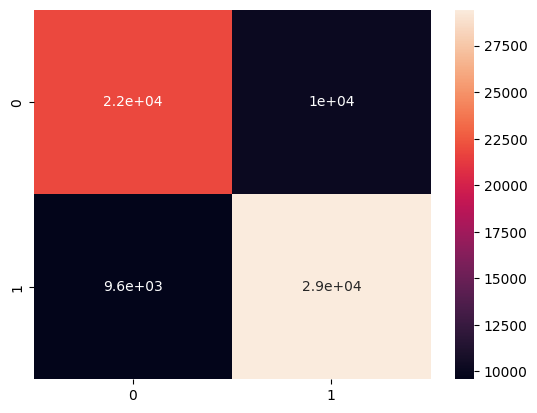

In [ ]:

sn.heatmap(cm_test_xgb, annot=True)


In [18]:
#tn = TabNetClassifier(verbose=1, seed=42,device_name='cuda')
tn = TabNetClassifier(verbose=1, seed=42)
# Load dataset
data = play_data

# Separate target from predictors
y = data['Winner']
X = data.drop('Winner', axis=1)

# Train-test split
y_train_tn = train_df['Winner']
y_valid_tn = valid_df['Winner']
y_test_tn = test_df['Winner']
X_train_tn = train_df.drop('Winner', axis=1)
X_valid_tn = valid_df.drop('Winner', axis=1)
X_test_tn = test_df.drop('Winner', axis=1)

# Separate target from predictors
# y = data['Winner']
# X = data.drop('Winner', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
y_valid_tn = y_valid_tn.astype(int)
y_train_tn = y_train_tn.astype(int)
y_test_tn = y_test_tn.astype(int)
cardinality_cols = ['type_text', 'team_play', 'start_down', 'end_down', 'season', 'week', 'Home_teamname', 'Away_teamname', 'leading_Team']
numerical_cols = ['GameID','scoring_game','point_difference','awayScore', 'homeScore', 'scoreValue', 'statYardage', 'quarter', 'clock', 'start_distance', 'start_yardlinie', 'start_yardsToEndzone', 'end_distance', 'end_yardlinie', 'end_yardsToEndzone', 'elo_score_away', 'elo_score_home', 'attendence', 'time_remaining']
# Preprocessing for numerical columns
scaler = StandardScaler()
X_train_numerical_tn = scaler.fit_transform(X_train_tn[numerical_cols])
X_valid_numerical_tn = scaler.transform(X_valid_tn[numerical_cols])
X_test_numerical_tn = scaler.transform(X_test_tn[numerical_cols])

# Preprocessing for categorical columns
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_tn = encoder.fit_transform(X_train_tn[cardinality_cols]).toarray()
X_valid_categorical_tn = encoder.transform(X_valid_tn[cardinality_cols]).toarray()
X_test_categorical_tn = encoder.transform(X_test_tn[cardinality_cols]).toarray()

# Concatenate the preprocessed numerical and categorical data
X_train_processed_tn = np.concatenate([X_train_numerical_tn, X_train_categorical_tn], axis=1)
X_valid_processed_tn = np.concatenate([X_valid_numerical_tn, X_valid_categorical_tn], axis=1)
X_test_processed_tn = np.concatenate([X_test_numerical_tn, X_test_categorical_tn], axis=1)

# Preprocess the raw training data and fit the model
tn.fit(
    X_train=X_train_processed_tn,
    y_train=y_train_tn,
    #patience=15,
    max_epochs=32,
    eval_set=[(X_valid_processed_tn, y_valid_tn)],
    eval_metric=['accuracy', 'auc'],
    batch_size=32
)

# Preprocess the raw validation data and make predictions
preds_test_tn = tn.predict(X_test_processed_tn)

accuracy_test_tn = accuracy_score(y_test_tn, preds_test_tn)
precision_test_tn = precision_score(y_test_tn, preds_test_tn)
recall_test_tn = recall_score(y_test_tn, preds_test_tn)
f1_test_tn = f1_score(y_test_tn, preds_test_tn)
auc_test_tn = roc_auc_score(y_test_tn, preds_test_tn)
cm_test_tn = confusion_matrix(y_test_tn, preds_test_tn)
cm_str_test_tn = np.array2string(cm_test_tn, separator=', ')

print("Test Accuracy: {:.2f}".format(accuracy_test_tn))
print("Test Precision: {:.2f}".format(precision_test_tn))
print("Test Recall: {:.2f}".format(recall_test_tn))
print("Test F1 Score: {:.2f}".format(f1_test_tn))
print('Test Confusion Matrix: ', cm_str_test_tn)
tn_filename = "/content/drive/MyDrive/seminar/tnAll_3.pkl"
with open(tn_filename, 'wb') as file:
    pickle.dump(tn, file)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.25324 | val_0_accuracy: 0.62175 | val_0_auc: 0.66096 |  0:03:47s
epoch 1  | loss: 0.05069 | val_0_accuracy: 0.56991 | val_0_auc: 0.59559 |  0:07:27s
epoch 2  | loss: 0.03263 | val_0_accuracy: 0.60447 | val_0_auc: 0.62564 |  0:11:08s
epoch 3  | loss: 0.02674 | val_0_accuracy: 0.60214 | val_0_auc: 0.63483 |  0:14:47s
epoch 4  | loss: 0.02124 | val_0_accuracy: 0.61754 | val_0_auc: 0.65853 |  0:18:29s
epoch 5  | loss: 0.01885 | val_0_accuracy: 0.60591 | val_0_auc: 0.63485 |  0:22:10s
epoch 6  | loss: 0.0187  | val_0_accuracy: 0.60511 | val_0_auc: 0.63893 |  0:25:50s
epoch 7  | loss: 0.01549 | val_0_accuracy: 0.60267 | val_0_auc: 0.63126 |  0:29:32s
epoch 8  | loss: 0.01435 | val_0_accuracy: 0.62162 | val_0_auc: 0.64863 |  0:33:14s
epoch 9  | loss: 0.01373 | val_0_accuracy: 0.61142 | val_0_auc: 0.64982 |  0:36:56s
epoch 10 | loss: 0.01321 | val_0_accuracy: 0.62999 | val_0_auc: 0.64893 |  0:40:38s
epoch 11 | loss: 0.01196 | val_0_accuracy: 0.5991  | val_0_auc: 0.62817 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test Accuracy: 0.64
Test Precision: 0.65
Test Recall: 0.73
Test F1 Score: 0.69
Test Confusion Matrix:  [[17002, 15015],
 [10356, 28420]]


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Train-validation split
train_accs = []
valid_accs = []

# Try different numbers of trees
n_estimators = [10, 50, 100, 200, 300, 400, 500]
y_train_rf = train_df['Winner']
y_valid_rf = valid_df['Winner']
y_test_rf = test_df['Winner']
X_train_rf = train_df.drop('Winner', axis=1)
X_valid_rf = valid_df.drop('Winner', axis=1)
X_test_rf = test_df.drop('Winner', axis=1)

# Separate target from predictors
y_valid_rf = y_valid_rf.astype(int)
y_train_rf = y_train_rf.astype(int)
y_test_rf = y_test_rf.astype(int)
cardinality_cols = ['GameID','type_text', 'team_play', 'start_down', 'end_down', 'season', 'week', 'Home_teamname', 'Away_teamname', 'leading_Team']
numerical_cols = ['scoring_game','point_difference','awayScore', 'homeScore', 'scoreValue', 'statYardage', 'quarter', 'clock', 'start_distance', 'start_yardlinie', 'start_yardsToEndzone', 'end_distance', 'end_yardlinie', 'end_yardsToEndzone', 'elo_score_away', 'elo_score_home', 'attendence', 'time_remaining']

# Preprocessing for numerical columns
scaler = StandardScaler()
X_train_numerical_rf = scaler.fit_transform(X_train_rf[numerical_cols])
X_valid_numerical_rf = scaler.transform(X_valid_rf[numerical_cols])
X_test_numerical_rf = scaler.transform(X_test_rf[numerical_cols])

# Preprocessing for categorical columns
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_rf = encoder.fit_transform(X_train_rf[cardinality_cols]).toarray()
X_valid_categorical_rf = encoder.transform(X_valid_rf[cardinality_cols]).toarray()
X_test_categorical_rf = encoder.transform(X_test_rf[cardinality_cols]).toarray()

# Concatenate the preprocessed numerical and categorical data
X_train_processed_rf = np.concatenate([X_train_numerical_rf, X_train_categorical_rf], axis=1)
X_valid_processed_rf = np.concatenate([X_valid_numerical_rf, X_valid_categorical_rf], axis=1)
X_test_processed_rf = np.concatenate([X_test_numerical_rf, X_test_categorical_rf], axis=1)


for n in n_estimators:
    # Train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n, random_state=0)
    rf_model.fit(X_train_processed_rf, y_train_rf)

    # Make predictions on the training and validation data
    preds_train_rf = rf_model.predict(X_train_processed_rf)
    preds_valid_rf = rf_model.predict(X_valid_processed_rf)

    # Calculate accuracy for training and validation data
    train_acc = accuracy_score(y_train_rf, preds_train_rf)
    valid_acc = accuracy_score(y_valid_rf, preds_valid_rf)

    # Append accuracies to the lists
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

# Plot the validation curve
plt.plot(n_estimators, train_accs, label='Training Accuracy')
plt.plot(n_estimators, valid_accs, label='Validation Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Curve: Random Forest')
plt.show()


KeyboardInterrupt: ignored

In [10]:
!pip install culm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement culm (from versions: none)
ERROR: No matching distribution found for culm


In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Random Forest-Modell initialisieren
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

# Trainings-, Validierungs- und Testdaten aufteilen
y_train_rf = train_df['Winner']
y_valid_rf = valid_df['Winner']
y_test_rf = test_df['Winner']
X_train_rf = train_df.drop('Winner', axis=1)
X_valid_rf = valid_df.drop('Winner', axis=1)
X_test_rf = test_df.drop('Winner', axis=1)

# Zielfeature von den Prädiktoren trennen
y_valid_rf = y_valid_rf.astype(int)
y_train_rf = y_train_rf.astype(int)
y_test_rf = y_test_rf.astype(int)

# Kategorische Spalten und numerische Spalten definieren
cardinality_cols = ['GameID','type_text', 'team_play', 'start_down', 'end_down', 'season', 'week', 'Home_teamname', 'Away_teamname', 'leading_Team']
numerical_cols = ['scoring_game','point_difference','awayScore', 'homeScore', 'scoreValue', 'statYardage', 'quarter', 'clock', 'start_distance', 'start_yardlinie', 'start_yardsToEndzone', 'end_distance', 'end_yardlinie', 'end_yardsToEndzone', 'elo_score_away', 'elo_score_home', 'attendence', 'time_remaining']


# Numerische Spalten vorverarbeiten
scaler = StandardScaler()
X_train_numerical_rf = scaler.fit_transform(X_train_rf[numerical_cols])
X_valid_numerical_rf = scaler.transform(X_valid_rf[numerical_cols])
X_test_numerical_rf = scaler.transform(X_test_rf[numerical_cols])

# Kategoriale Spalten vorverarbeiten
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_rf = encoder.fit_transform(X_train_rf[cardinality_cols]).toarray()
X_valid_categorical_rf = encoder.transform(X_valid_rf[cardinality_cols]).toarray()
X_test_categorical_rf = encoder.transform(X_test_rf[cardinality_cols]).toarray()

# Vorverarbeitete numerische und kategoriale Daten zusammenfügen
X_train_processed_rf = np.concatenate([X_train_numerical_rf, X_train_categorical_rf], axis=1)
X_valid_processed_rf = np.concatenate([X_valid_numerical_rf, X_valid_categorical_rf], axis=1)
X_test_processed_rf = np.concatenate([X_test_numerical_rf, X_test_categorical_rf], axis=1)

# Modell trainieren
rf_model.fit(X=X_train_processed_rf,
              y=y_train_rf)

# Testdaten vorhersagen
preds_test_rf = rf_model.predict(X_test_processed_rf)

# Testmetriken berechnen
accuracy_test_rf = accuracy_score(y_test_rf, preds_test_rf)
precision_test_rf = precision_score(y_test_rf, preds_test_rf)
recall_test_rf = recall_score(y_test_rf, preds_test_rf)
f1_test_rf = f1_score(y_test_rf, preds_test_rf)
auc_test_rf = roc_auc_score(y_test_rf, preds_test_rf)
cm_test_rf = confusion_matrix(y_test_rf, preds_test_rf)
cm_str_test_rf = np.array2string(cm_test_rf, separator=', ')

# Ergebnisse ausgeben
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_test_rf)
print("Precision:", precision_test_rf)
print("Recall:", recall_test_rf)
print("F1 Score:", f1_test_rf)
print("AUC:", auc_test_rf)
print("Confusion Matrix:\n", cm_str_test_rf)


Test Set Metrics:
Accuracy: 0.733688359018547
Precision: 0.7175522505405229
Recall: 0.8473282442748091
F1 Score: 0.7770590669898895
AUC: 0.7216932941397783
Confusion Matrix:
 [[19084, 12933],
 [ 5920, 32856]]


In [ ]:
# Trainings-, Validierungs- und Testdaten aufteilen
y_train_rf = train_df['Winner']
y_valid_rf = valid_df['Winner']
y_test_rf = test_df['Winner']
X_train_rf = train_df.drop('Winner', axis=1)
X_valid_rf = valid_df.drop('Winner', axis=1)
X_test_rf = test_df.drop('Winner', axis=1)

# Zielfeature von den Prädiktoren trennen
y_valid_rf = y_valid_rf.astype(int)
y_train_rf = y_train_rf.astype(int)
y_test_rf = y_test_rf.astype(int)

# Kategorische Spalten und numerische Spalten definieren
cardinality_cols = ['GameID','type_text', 'team_play', 'start_down', 'end_down', 'season', 'week', 'Home_teamname', 'Away_teamname', 'leading_Team']
numerical_cols = ['scoring_game','point_difference','awayScore', 'homeScore', 'scoreValue', 'statYardage', 'quarter', 'clock', 'start_distance', 'start_yardlinie', 'start_yardsToEndzone', 'end_distance', 'end_yardlinie', 'end_yardsToEndzone', 'elo_score_away', 'elo_score_home', 'attendence', 'time_remaining']
# Numerische Spalten vorverarbeiten
scaler = StandardScaler()
X_train_numerical_rf = scaler.fit_transform(X_train_rf[numerical_cols])
X_valid_numerical_rf = scaler.transform(X_valid_rf[numerical_cols])
X_test_numerical_rf = scaler.transform(X_test_rf[numerical_cols])

# Kategoriale Spalten vorverarbeiten
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_rf = encoder.fit_transform(X_train_rf[cardinality_cols]).toarray()
X_valid_categorical_rf = encoder.transform(X_valid_rf[cardinality_cols]).toarray()
X_test_categorical_rf = encoder.transform(X_test_rf[cardinality_cols]).toarray()

# Vorverarbeitete numerische und kategoriale Daten zusammenfügen
X_train_processed_rf = np.concatenate([X_train_numerical_rf, X_train_categorical_rf], axis=1)
X_valid_processed_rf = np.concatenate([X_valid_numerical_rf, X_valid_categorical_rf], axis=1)
X_test_processed_rf = np.concatenate([X_test_numerical_rf, X_test_categorical_rf], axis=1)

In [8]:
rf_filename = "/content/drive/MyDrive/seminar/rfAll_2.pkl"
with open(rf_filename, 'wb') as file:
    pickle.dump(rf_model, file)



In [16]:
rf_filename = "/content/drive/MyDrive/seminar/rfAll_2.pkl"
with open(rf_filename, 'rb') as file:
    rf_model = pickle.load(file)

In [17]:
preds_test_rf = rf_model.predict(X_test_processed_rf)

NameError: ignored

In [13]:
accuracy_test_rf = accuracy_score(y_test_rf, preds_test_rf)
precision_test_rf = precision_score(y_test_rf, preds_test_rf)
recall_test_rf = recall_score(y_test_rf, preds_test_rf)
f1_test_rf = f1_score(y_test_rf, preds_test_rf)
auc_test_rf = roc_auc_score(y_test_rf, preds_test_rf)
cm_test_rf = confusion_matrix(y_test_rf, preds_test_rf)
cm_str_test_rf = np.array2string(cm_test_rf, separator=', ')

# Ergebnisse ausgeben
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_test_rf)
print("Precision:", precision_test_rf)
print("Recall:", recall_test_rf)
print("F1 Score:", f1_test_rf)
print("AUC:", auc_test_rf)
print("Confusion Matrix:\n", cm_str_test_rf)


Test Set Metrics:
Accuracy: 0.733688359018547
Precision: 0.7175522505405229
Recall: 0.8473282442748091
F1 Score: 0.7770590669898895
AUC: 0.7216932941397783
Confusion Matrix:
 [[19084, 12933],
 [ 5920, 32856]]


In [ ]:
def plot_data_xgb(timer):
  preds_time_xgb = preds_test_xgb[((X_test_xgb['time_remaining'] <= time) &(X_test_xgb['time_remaining'] >= time-0.5))]
  y_time_xgb = y_test_xgb[((X_test_xgb['time_remaining'] <= time) & (X_test_xgb['time_remaining'] >= time-0.5))]
  accuracy = accuracy_score(y_time_xgb, preds_time_xgb)
  return accuracy

In [ ]:
def plot_data_tn(time, quarter):
  preds_time_tn = preds_test_tn[((X_test_tn['clock'] <= time) & (X_test_tn['quarter'] == quarter) & (X_test_tn['clock'] >= time-1))]
  y_time = y_test_tn[((X_test_tn['clock'] <= time) & (X_test_tn['quarter'] == quarter) & (X_test_tn['clock'] >= time-1))]
  accuracy = accuracy_score(y_time, preds_time_tn)
  return accuracy

In [ ]:
def plot_data_rf(time, quarter):
  preds_time_rf = preds_test_rf[((X_test_xgb['clock'] <= time) & (X_test_xgb['quarter'] == quarter) & (X_test_xgb['clock'] >= time-1))]
  y_time = y_test_rf[((X_test_xgb['clock'] <= time) & (X_test_xgb['quarter'] == quarter) & (X_test_xgb['clock'] >= time-1))]
  accuracy = accuracy_score(y_time, preds_time_rf)
  print(time)
  print(quarter)
  print(accuracy)
  return accuracy

In [ ]:
time_values = list(np.arange(15, 0, -3))
print(time_values)

[15, 12, 9, 6, 3]


In [ ]:
time_values = list(np.arange(60, 0, -0.5))
quarter_values = list(np.arange(1, 5, 1))
auc_values_xgb=[]
time_plot=[]

for time in time_values:
    auc_values_xgb.append(plot_data_xgb(time))
    print(plot_data_xgb(time))
    time_plot.append(time)






0.6058763931104356
0.624031007751938
0.5961123110151187
0.6439232409381663
0.6036960985626283
0.6209150326797386
0.64453125
0.553941908713693
0.6337448559670782
0.6095617529880478
0.6015180265654649
0.6
0.6169354838709677
0.6494252873563219
0.5915492957746479
0.6325678496868476
0.6116504854368932
0.639921722113503
0.6209677419354839
0.6522633744855967
0.6175869120654397
0.6428571428571429
0.6286307053941909
0.6666666666666666
0.6117424242424242
0.6647727272727273
0.6470588235294118
0.6093117408906883
0.6463878326996197
0.6341263330598852
0.6605584642233857
0.6418918918918919
0.6045548654244306
0.6471816283924844
0.6604477611940298
0.6427104722792608
0.6291913214990138
0.6551020408163265
0.66015625
0.6733466933867736
0.6978967495219885
0.6472945891783567
0.6653771760154739
0.6892430278884463
0.7029126213592233
0.6725490196078432
0.6777546777546778
0.6673469387755102
0.6772908366533864
0.7136752136752137
0.7129455909943715
0.7199211045364892
0.7026515151515151
0.6955719557195572
0.695099

In [ ]:
time_values = list(np.arange(15, -1, -1))
quarter_values = list(np.arange(1, 5, 1))
auc_values_tn=[]
time_plot=[]
for quarter in quarter_values:
  for time in time_values:
    auc_values_tn.append(plot_data_tn(time,quarter))
    if quarter == 1:
      time_plot.append(time+45)
    elif quarter ==2:
      time_plot.append(time+30)
    elif quarter == 3:
      time_plot.append(time+15)
    elif quarter == 4:
      time_plot.append(time)


In [ ]:
preds_time_xgb = preds_test_xgb[((X_test_xgb['clock'] <= 1) & (X_test_xgb['quarter'] == 2) &(X_test_xgb['clock'] > 0)&(X_test_xgb['scoring_game'] == 2))]
y_time = y_test_xgb[((X_test_xgb['clock'] <= 1) & (X_test_xgb['quarter'] == 2) & (X_test_xgb['clock'] >0)&(X_test_xgb['scoring_game'] == 2))]
accuracy = accuracy_score(y_time, preds_time_xgb)
print(accuracy)

0.8431568431568431


In [ ]:
time_values = list(np.arange(15, -1, -1))
quarter_values = list(np.arange(1, 5, 1))
auc_values_rf=[]
time_plot=[]
for quarter in quarter_values:
  for time in time_values:
    auc_values_rf.append(plot_data_rf(time,quarter))
    if quarter == 1:
      time_plot.append(time+45)
    elif quarter ==2:
      time_plot.append(time+30)
    elif quarter == 3:
      time_plot.append(time+15)
    elif quarter == 4:
      time_plot.append(time)


NameError: ignored

In [ ]:
selected_values = X_test_xgb[(X_test_xgb['time_remaining'] < 0.5) & (X_test_xgb['time_remaining'] >=0)&(X_test_xgb['scoring_game'] >= 2)]

In [ ]:
selected_values

,GameID,playID,awayScore,homeScore,scoreValue,statYardage,quarter,clock,type_text,team_play,...,week,Home_teamname,Away_teamname,elo_score_away,elo_score_home,attendence,time_remaining,leading_Team,point_difference,scoring_game
285781,401326451,4013264514379,30,45,0,0,4,0.000000,End of Game,NoTeam,...,9,ind,nyj,1342.19,1543.99,0.945921,0.000000,ind,15.0,3
285941,401326454,4013264543976,41,16,0,9,4,0.366667,Rush,cin,...,9,cin,cle,1512.59,1518.82,0.999023,0.366667,cle,25.0,4
285942,401326454,4013264543997,41,16,0,0,4,0.000000,End of Game,NoTeam,...,9,cin,cle,1512.59,1518.82,0.999023,0.000000,cle,25.0,4
286114,401326455,4013264554132,30,16,0,0,4,0.000000,End of Game,NoTeam,...,9,dal,den,1446.13,1567.17,0.935030,0.000000,den,14.0,2
286787,401326453,4013264533800,24,6,0,0,4,0.000000,End of Game,NoTeam,...,9,car,ne,1511.13,1449.78,0.978652,0.000000,ne,18.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354762,401437950,4014379503931,29,13,0,0,4,0.000000,End of Game,NoTeam,...,18,chi,min,1545.62,1336.91,0.975724,0.000000,min,16.0,3
355591,401437958,4014379584010,14,28,0,-7,4,0.166667,Sack,cle,...,18,pit,cle,1516.53,1533.11,0.950570,0.166667,pit,14.0,2
355592,401437958,4014379584029,14,28,0,0,4,0.000000,End of Game,NoTeam,...,18,pit,cle,1516.53,1533.11,0.950570,0.000000,pit,14.0,2
356090,401437962,4014379623612,13,38,0,-1,4,0.433333,Rush,ari,...,18,sf,ari,1387.99,1693.13,1.045810,0.433333,sf,25.0,4


In [ ]:
time_plot = time_plot[::-1]
auc_values = auc_values

In [ ]:
print(len(time_plot))

16


In [ ]:
print(len(auc_values_xgb))

16


In [ ]:
print(len(auc_values_tn))

16


In [ ]:


pkl_filename = "/content/drive/MyDrive/seminar/rf.pkl"
with open(pkl_filename, 'wb') as file:
    clf = pickle.load(file)

NameError: ignored

In [ ]:
pkl_filename = "/content/drive/MyDrive/seminar/rf.pkl"
with open(pkl_filename, 'rb') as file:
    clf = pickle.load(file)

EOFError: ignored

In [ ]:
preds_test_rf = clf.predict(X_test_processed_rf)

In [ ]:
unt

array([1, 1, 1, ..., 0, 0, 0])

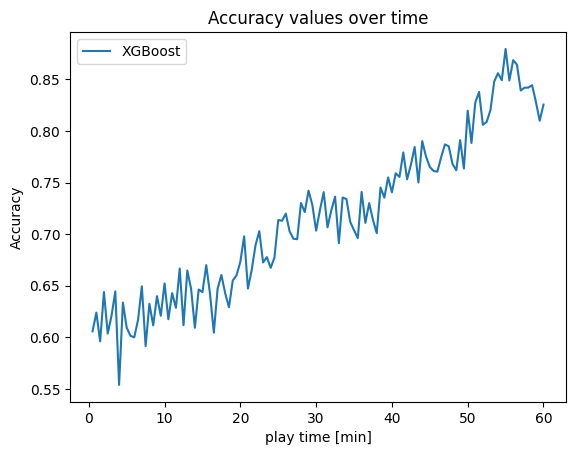

In [ ]:
import matplotlib.pyplot as plt

# Beispielwerte
x = time_plot[::-1]
y_xgb = auc_values_xgb
#y_tn = auc_values_tn
#y_rf = auc_values_rf

# Erstellen der Liniengrafik
plt.plot(x, y_xgb, label='XGBoost')
#plt.plot(x, y_tn, label='Tabnet')
#plt.plot(x, y_rf, label='Random Forest')

# Achsentitel und Diagrammtitel hinzufügen
plt.xlabel('play time [min]')
plt.ylabel('Accuracy')
plt.title('Accuracy values over time')

# Legende anzeigen
plt.legend()

# Anzeigen der Grafik
plt.show()